In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preprocess import Preprocess
import tensorflow as tf
import rrn

/Users/larry/Py3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Load Data and user/item vectors

In [8]:
df = pd.read_csv('../data/class/rating_data.csv')
df['freq'] = df.groupby('uid')['uid'].transform('count')  # count frequncy by column's values
df = df[df['freq'] > 5]  # remove row which corresponding frequence < 5

user_vectors = np.load('../data/class/user_vectors.npy')
item_vectors = np.load('../data/class/item_vectors.npy')

user_time_interval = 3 * 30
item_time_interval = 3 * 30

# Top List preprocess

In [9]:
df_item = pd.DataFrame(df['iid'])
df_item.column = ['iid']
df_item['freq'] = df_item.groupby('iid')['iid'].transform('count')
df_item = df_item.drop_duplicates()
df_item = df_item.sort_values(by=['freq'], ascending=False)
top_list = df_item['iid'].as_matrix()

top_ranks = []
for i in range(1, 10):
    top_ranks.append(top_list[:i*10])

# Data preprocessing

In [10]:
import math
def get_map(list_):
    map_ = {}
    for idx, ident in enumerate(list_):
        map_[ident] = idx
        
    return map_

def train_test_split(df, time_interval, split_rate= 0.125):
    start_time = min(df['timestamp'])
    end_time = max(df['timestamp'])
    time_elapse = (end_time-start_time) // time_interval
    split_time = start_time + math.floor(time_elapse * (1-split_rate)) * time_interval
    
    df_train = df[df['timestamp'] < split_time]
    df_test = df[df['timestamp'] >= split_time]
    
    return df_train, df_test

In [11]:
userList = np.unique(df['uid'])
itemList = np.unique(df['iid'])
user_map = get_map(userList)
item_map = get_map(itemList)
initial_time = min(df['timestamp'])

df_train, df_test = train_test_split(df, user_time_interval * 24 * 3600, split_rate=0.5)

## Set Hyperparameter

In [12]:
def get_hparas(batch_size, vector_length, time_interval, name):
    hparas={
        'NAME': name,
        'EMBED_UNITS': 40,
        'BATCH_SIZE': batch_size,
        'LSTM_UNITS': 40,
        'LATENT_UNITS': 20,
        'VECTOR_LENGTH': vector_length+3,
        'TRAIN_TIME_ELAPSE': 21,
        'TEST_TIME_ELAPSE': 3,
        'STATIONARY_LENGTH': 20,
        'TIME_INTERVAL': time_interval,
    }
    
    return hparas

item_train_list = np.unique(df_train['iid'])
item_test_list = np.unique(df_test['iid'])

user_train_hparas = get_hparas(64, len(itemList), user_time_interval, 'USER')
item_train_hparas = get_hparas(len(item_train_list), len(userList), item_time_interval, 'ITEM')
user_test_hparas = get_hparas(64, len(itemList), user_time_interval, 'USER')
item_test_hparas = get_hparas(len(item_test_list), len(userList), item_time_interval, 'ITEM')

# Train

100%|██████████| 200/200 [00:26<00:00,  7.47it/s]


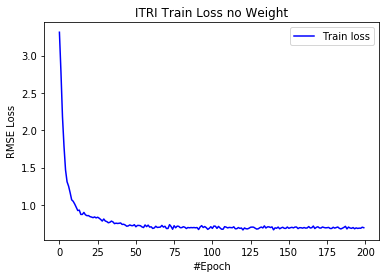

In [29]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_train_hparas, item_hparas=item_train_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=True, lr=0.01, epochs=200, loss_function='log_loss', weighted=None)

model.train(df_train, user_map, item_map, initial_time, top_rank=None)
model.model_save('class_log_loss')

train_loss = model.log['train_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.title("ITRI Train Loss no Weight")
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('RMSE Loss')
# plt.savefig("Train_Loss_with_weight_50.jpg")
plt.show()

100%|██████████| 200/200 [00:26<00:00,  7.58it/s]


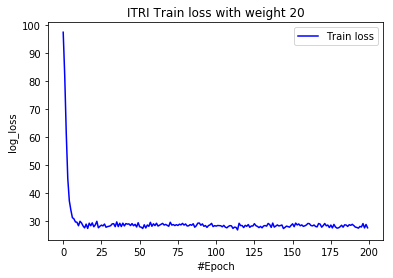

In [26]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_train_hparas, item_hparas=item_train_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=True, lr=0.01, epochs=200, loss_function='log_loss', weighted=100)

model.train(df_train, user_map, item_map, initial_time, top_rank=top_ranks[2])
model.model_save('class_log_loss_weight_80')

train_loss = model.log['train_loss']
plt.plot(range(len(train_loss)), train_loss, color='blue', label='Train loss')
plt.title("ITRI Train loss with weight 20")
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('log_loss')
# plt.savefig("Train_Loss_with_weight_20.jpg")
plt.show()

# Test

## ITRI dataset
**LOG_LOSS** (no weighted)

In [28]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load('class_log_loss_weight_80')

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

INFO:tensorflow:Restoring parameters from model/rrn_class_log_loss_weight_80.ckpt
top10 log_loss loss: 0.075731
top20 log_loss loss: 0.151130
top30 log_loss loss: 0.222365
top40 log_loss loss: 0.296027
top50 log_loss loss: 0.368923
top60 log_loss loss: 0.441197
top70 log_loss loss: 0.512466
top80 log_loss loss: 0.582219
top90 log_loss loss: 0.652304

All items log_loss loss: 0.716483


## Class dataset
**RMSE** (with weighted)

In [30]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load('class_log_loss')

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

INFO:tensorflow:Restoring parameters from model/rrn_class_log_loss.ckpt
top10 log_loss loss: 0.075732
top20 log_loss loss: 0.151130
top30 log_loss loss: 0.222365
top40 log_loss loss: 0.296028
top50 log_loss loss: 0.368923
top60 log_loss loss: 0.441198
top70 log_loss loss: 0.512466
top80 log_loss loss: 0.582219
top90 log_loss loss: 0.652304

All items log_loss loss: 0.716483


## Itri dataset 
**LOG_LOSS** (without weighted)

In [ ]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load('itri_log_loss')

# for i in top_ranks:
#     losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
#     print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
# print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

## Itri dataset 
**LOG_LOSS** (with weighted)

In [ ]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, loss_function='log_loss')

model.model_load('class_log_loss_weighted')

for i in top_ranks:
    losses = model.test(df_test, user_map, item_map, initial_time, individually=True, top_rank=i)
    print ("top%d %s loss: %f" % (len(i), model.loss_function, sum(losses)/len(losses)))
    
print ()
losses = model.test(df_test, user_map, item_map, initial_time, individually=False, top_rank=None)
print ("All items %s loss: %f" % (model.loss_function, sum(losses)/len(losses)))

# Debug Section

In [ ]:
tf.reset_default_graph()

model = rrn.RRN(user_hparas=user_test_hparas, item_hparas=item_test_hparas, 
                user_vectors=user_vectors, item_vectors=item_vectors,
                is_train=False, lr=0.01, epochs=100, loss_function='log_loss')
model.model_load('itri_log_loss')

In [ ]:
sequential_loss = []
prep = Preprocess(
    df_test, user_map, item_map, initial_time, 'rating', 
    user_time_interval=model.user_hparas['TIME_INTERVAL'], 
    item_time_interval=model.item_hparas['TIME_INTERVAL'])

user_input, item_input, ground_truth, batch_user, batch_item = prep.gen_batch(0)
u_static_vector = prep.get_latent_vector(batch_user, user_vectors, 'user')
i_static_vector = prep.get_latent_vector(batch_item, item_vectors, 'item')
weight_list = prep.get_list_weight(top_ranks[2], model.weighted)